### Housekeeping

In [1]:
import sys
print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

Python version
3.5.3 (default, Sep 27 2018, 17:25:39) 
[GCC 6.3.0 20170516]
Version info.
sys.version_info(major=3, minor=5, micro=3, releaselevel='final', serial=0)


In [2]:
import os
import pandas as pd
import random
import numpy as np
import librosa
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import datetime as datetime
import itertools
from collections import defaultdict
import random
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, precision_score, average_precision_score

import ibm_boto3
from ibm_botocore.client import Config, ClientError

import tensorflow as tf
import keras
from keras import layers, models, Input, optimizers, metrics, regularizers
from keras import backend as K

SEED = 101
random.seed(SEED)

print(tf.__version__)

1.15.2


Using TensorFlow backend.


### Loading files from bucket

In [3]:
DATA_PATH = '/home/csanc/'
BUCKET_NAME = 'cv-audio'
DEV_FILE = 'dev.tsv'
AUDIO_FILE = 'dev-clips.tgz'
MFCC_PICKLE = 'mfcc.bin'
CLIPS_PATH = DATA_PATH + 'dev-clips/'
TEST_CLIPS = DATA_PATH + 'test-clips/'
BEST_MODEL_FILE = 'EN-TF1-20200405-024254.tgz'
TEST_RECORDINGS = 'test-clips.tgz'

In [4]:
os.listdir(DATA_PATH)

['.cache',
 'mfcc.bin',
 'test-clips',
 '.bashrc',
 'nohup.out',
 'OneShot_Speech_Carlos_EN-TF1.ipynb',
 'logs',
 '.jupyter',
 '.bash_logout',
 '.ipython',
 'checkpoints',
 '.ssh',
 '.bash_history',
 '.local',
 '.profile',
 '.nv',
 '.config',
 '.docker',
 'test-clips.tgz',
 '.bluemix',
 '.ipynb_checkpoints',
 '.keras']

In [50]:
# Constants for IBM S3 values
COS_ENDPOINT = ''
COS_API_KEY_ID = ''
COS_AUTH_ENDPOINT = ''
COS_RESOURCE_CRN = ''

# Create resource
cos = ibm_boto3.resource("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint=COS_AUTH_ENDPOINT,
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

In [ ]:
bucket = cos.Bucket(BUCKET_NAME)
obj = bucket.Object(DEV_FILE)

with open(DATA_PATH + DEV_FILE, 'wb') as data:
    obj.download_fileobj(data)

In [51]:
bucket = cos.Bucket(BUCKET_NAME)
obj = bucket.Object(TEST_RECORDINGS)

with open(DATA_PATH + TEST_RECORDINGS, 'wb') as data:
    obj.download_fileobj(data)

In [ ]:
bucket = cos.Bucket(BUCKET_NAME)
obj = bucket.Object(AUDIO_FILE)

with open(DATA_PATH + AUDIO_FILE, 'wb') as data:
    obj.download_fileobj(data)

### Save files to the bucket

In [42]:
# Create resource
cos = ibm_boto3.client(
    service_name="s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint=COS_AUTH_ENDPOINT,
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

In [ ]:
with open(DATA_PATH + TEST_RECORDINGS, 'rb') as data:
    cos.upload_fileobj(data, BUCKET_NAME, TEST_RECORDINGS)

In [48]:
with open(DATA_PATH + 'checkpoints/'  + BEST_MODEL_FILE, 'rb') as data:
    cos.upload_fileobj(data, BUCKET_NAME, BEST_MODEL_FILE)

In [45]:
DATA_PATH + 'checkpoints/'  + BEST_MODEL_FILE

'/home/csanc/checkpoints/model-EN-20200329-133052.tgz'

In [ ]:
DATA_PATH + BEST_MODEL_FILE
with open(DATA_PATH+ MFCC_PICKLE, 'rb') as data:
    cos.upload_fileobj(data, BUCKET_NAME, MFCC_PICKLE)

In [49]:
cos = ibm_boto3.resource("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint=COS_AUTH_ENDPOINT,
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

for file in cos.Bucket(BUCKET_NAME).objects.all():
    print("Item: {0} ({1} bytes).".format(file.key, file.size))

Item: EN-TF1-20200405-024254.tgz (50895219 bytes).
Item: dev-clips-wav.tgz (372144992 bytes).
Item: dev-clips.tgz (729032372 bytes).
Item: dev.tsv (3555470 bytes).
Item: en-clips.tgz (41357019402 bytes).
Item: mfcc.bin (499906808 bytes).
Item: model-EN-20200329-133052.tgz (152577527 bytes).
Item: test-clips.tgz (992056 bytes).
Item: test.tsv (3401154 bytes).
Item: test.txt (4 bytes).
Item: train.tsv (55941783 bytes).


### EDA

In [ ]:
df = pd.read_csv(DATA_PATH + DEV_FILE, sep='\t')

In [ ]:
df.head()

In [ ]:
len(df)

In [ ]:
# check for unique voices 
df.nunique()

In [ ]:
# check for voices up_votes only
len(df[df.down_votes == 0]) / len(df)

In [ ]:
df[df.down_votes == 0].nunique()

In [ ]:
df.up_votes.unique().tolist()

In [ ]:
df.down_votes.unique().tolist()

In [ ]:
(df.up_votes < df.down_votes).sum()

In [ ]:
df.gender.value_counts()

In [ ]:
df.accent.value_counts()

### Pairing Data

In [ ]:
voices_by_path = {}
voices_by_id = defaultdict(lambda: list())
for x in df[['client_id', 'path']].values.tolist():
    voices_by_path.update({x[1]: x[0]})
    voices_by_id[x[0]].append(x[1])

In [ ]:
next(iter(voices_by_path.items()))

In [ ]:
next(iter(voices_by_id.items()))

In [ ]:
positive_pairs = []
sample_voices = []
for voices in voices_by_id.values():
    
    # saves one recording of each person to create negative pairs later
    sample_voices.append(voices[0])
    
    if(len(voices) < 2): continue
    # create all combinations of voices of the same person
    for left, right in itertools.combinations(voices, 2):
        positive_pairs.append([left, right, 1])    

In [ ]:
len(positive_pairs), len(sample_voices)

In [ ]:
positive_pairs[0:2]

In [ ]:
voices_by_id[voices_by_path['common_voice_en_20002398.mp3']]

In [ ]:
negative_pairs = []
for left, right in itertools.combinations(sample_voices, 2):
    negative_pairs.append([left, right, 0])

In [ ]:
len(negative_pairs)

In [ ]:
# sample a few negative pairs as there too many of them
negative_pairs = random.sample(negative_pairs, len(positive_pairs)*2)

In [ ]:
len(negative_pairs)

In [ ]:
all_pairs = positive_pairs + negative_pairs
random.shuffle(all_pairs)
all_pairs[0:10]

### Loading MP3 files

In [5]:
def get_clip(file_name, max_pad_len=400):
    wave, sr = librosa.load(file_name, mono=True)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=sr) 

    pad_width = max_pad_len - mfcc.shape[1]
    
    if (pad_width < 0): 
        pad_width = 0
        mfcc = mfcc[:, 0:max_pad_len]
    
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc.astype(np.float32)

In [ ]:
all_filenames = df['path'].values.tolist()

In [ ]:
len(all_filenames)

In [ ]:
clips = {}
for i in tqdm(range(len(all_filenames))):  
    path = CLIPS_PATH + all_filenames[i]
    clips.update({all_filenames[i]: get_clip(path)})

In [ ]:
with open(DATA_PATH + MFCC_PICKLE, 'wb') as f:
    pickle.dump((clips, all_pairs) , f)

In [ ]:
for i in clips.items():
    print(i[0])
    print(i[1])
    print(i[1].shape)
    break

In [ ]:
del(clips)

### Creating the Dataset

In [6]:
with open(DATA_PATH + MFCC_PICKLE, 'rb') as f:
    clips, all_pairs = pickle.load(f)

In [7]:
def get_dataset():
    left = []
    right = []
    labels = []  
    
    for pair in all_pairs:       
        left.append([clips.get(pair[0]).astype(np.float32)])
        right.append([clips.get(pair[1]).astype(np.float32)])
        labels.append(np.float32(pair[2]))          
    
    left = np.array(left).astype(np.float32)
    right = np.array(right).astype(np.float32)
    labels = np.array(labels).astype(np.float32)

    left = np.rollaxis(np.rollaxis(left, 3, 1), 3, 1)
    right = np.rollaxis(np.rollaxis(right, 3, 1), 3, 1)

    dataset_size = len(all_pairs)
    train_size = int(dataset_size*0.7)    
   
    return left[0:train_size], \
           left[train_size:dataset_size], \
           right[0:train_size], \
           right[train_size:dataset_size], \
           labels[0:train_size], \
           labels[train_size:dataset_size]

In [8]:
left_train, left_val, right_train, right_val, labels_train, labels_val = get_dataset()
left_train = left_train.astype(np.float32)
left_val = left_val.astype(np.float32)
right_train = right_train.astype(np.float32)
right_val = right_val.astype(np.float32)
labels_train = labels_train.astype(np.float32)
labels_val = labels_val.astype(np.float32)

In [10]:
print(left_train.shape, right_train.shape)

(48892, 20, 400, 1) (48892, 20, 400, 1)


In [11]:
print(left_val.shape, right_val.shape)

(20954, 20, 400, 1) (20954, 20, 400, 1)


In [12]:
print(labels_train.shape, labels_val.shape)

(48892,) (20954,)


### Create Model

In [9]:
def get_siamese_model():
  
    # Define the tensors for the two input images
    left_input = Input((20, 400, 1))
    right_input = Input((20, 400, 1))
    
    # Convolutional Neural Network
    model = models.Sequential()    
    model.add(layers.Conv2D(
        32, 
        (10,10), 
        padding = 'same',
        activation='relu', 
        input_shape=(20, 400, 1), 
        kernel_regularizer=regularizers.l2(2e-4)))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(
        64, 
        (7,7),  
        padding = 'same',
        activation='relu',
        kernel_regularizer=regularizers.l2(2e-4)))    
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(
        64, 
        (4,4), 
        padding = 'same', 
        activation='relu', 
        kernel_regularizer=regularizers.l2(2e-4)))
    model.add(layers.MaxPooling2D())
    
    model.add(layers.Conv2D(
        128, 
        (4,4),  
        padding = 'same',
        activation='relu', 
        kernel_regularizer=regularizers.l2(2e-4)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(
        1024, 
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(1e-3)))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = layers.Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = layers.Dense(1, activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = models.Model(inputs=[left_input, right_input],outputs=prediction)
    
    # return the model
    return siamese_net

### Training

In [19]:
model = get_siamese_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20, 400, 1)   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 20, 400, 1)   0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1024)         13408672    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1024)         0           sequential_2[1][0]         

In [20]:
LR = 1e-4
model.compile(loss="binary_crossentropy", optimizer = optimizers.Adam(lr = LR))

In [21]:
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

log_dir = DATA_PATH + 'logs/EN-TF1-' + now
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

checkpoint_path = DATA_PATH + 'checkpoints/EN-TF1-' + now
checkpoints_callback = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    save_weights_only=True,
    save_best_only = True,
    verbose=1)

In [22]:
print(checkpoint_path)
print(log_dir)

/home/csanc/checkpoints/EN-TF1-20200405-024254
/home/csanc/logs/EN-TF1-20200405-024254


In [23]:
BATCH = 512
EPOCHS = 200

history = model.fit(
   [left_train, right_train], 
    labels_train, 
    batch_size = BATCH, 
    epochs = EPOCHS,
    validation_data = ([left_val, right_val], labels_val),
    callbacks=[checkpoints_callback]) #, tensorboard_callback

Train on 48892 samples, validate on 20954 samples
Epoch 1/200
48892/48892 [==============================] - 70s 1ms/step - loss: 1.6362 - val_loss: 1.0131

Epoch 00001: val_loss improved from inf to 1.01313, saving model to /home/csanc/checkpoints/EN-TF1-20200405-024254
Epoch 2/200
48892/48892 [==============================] - 71s 1ms/step - loss: 0.7818 - val_loss: 0.6232

Epoch 00002: val_loss improved from 1.01313 to 0.62318, saving model to /home/csanc/checkpoints/EN-TF1-20200405-024254
Epoch 3/200
48892/48892 [==============================] - 71s 1ms/step - loss: 0.5398 - val_loss: 0.4961

Epoch 00003: val_loss improved from 0.62318 to 0.49611, saving model to /home/csanc/checkpoints/EN-TF1-20200405-024254
Epoch 4/200
48892/48892 [==============================] - 71s 1ms/step - loss: 0.4334 - val_loss: 0.4172

Epoch 00004: val_loss improved from 0.49611 to 0.41724, saving model to /home/csanc/checkpoints/EN-TF1-20200405-024254
Epoch 5/200
48892/48892 [=========================

In [24]:
print(history.history.keys())

dict_keys(['val_loss', 'loss'])


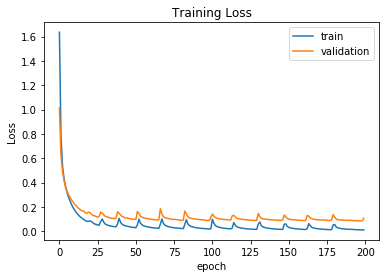

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [28]:
with open(checkpoint_path + '-history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

### Inference

In [10]:
def get_accuracy(labels, predicted_scores, threshold=0.5):
    predicted = predicted_scores > threshold
    predicted = predicted.astype(int).ravel()
    return np.round(100*accuracy_score(labels, predicted), 2)

In [11]:
def plot_roc_auc(actual, predictions):
    fpr, tpr, roc_thresholds = roc_curve(actual, predictions)
    auc_value = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='AUC  = {:.3f}'.format(auc_value))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [12]:
def plot_precision_recall(actual, predictions):
    precision, recall, pr_thresholds = precision_recall_curve(actual, predictions)
    avg_precision = average_precision_score(actual, predictions)
    plt.plot(recall, precision, label='Avg Precision  = {:.3f}'.format(avg_precision))
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title('Precision-Recall curve')
    plt.legend(loc='best')
    plt.show()

In [13]:
checkpoint_path = '/home/csanc/checkpoints/EN-TF1-20200405-024254'

In [14]:
model = get_siamese_model()
model.load_weights(checkpoint_path)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



#### Validation Set

In [15]:
predicted_val = model.predict([left_val, right_val]).ravel()

In [16]:
#accuracy is a misleading metric here, we should look for the precision-recall
#plot and select a threshold that priviledges precision but do not causes a 
#too low recall
print('accuracy:', get_accuracy(labels_val, predicted_val))

accuracy: 97.54


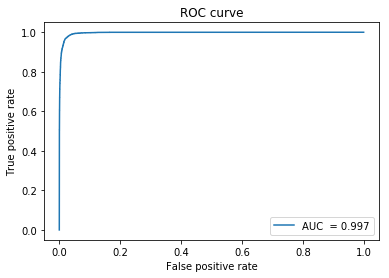

In [17]:
plot_roc_auc(labels_val, predicted_val)

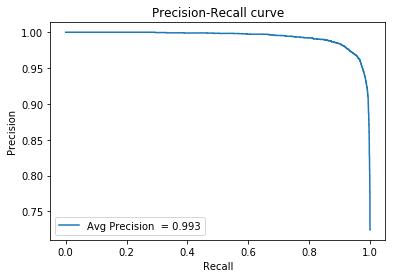

In [18]:
plot_precision_recall(labels_val, predicted_val)

#### Test Set

In [19]:
test_filenames = os.listdir(TEST_CLIPS)
test_filenames

['Xander_English_2.mp3',
 'Rose_Portuguese_3.m4a',
 'Other_Spanish_4.mp3',
 'Xander_English_5.m4a',
 'Xander_English_3.mp3',
 'Other_Spanish_5.mp3',
 'Xander_English_4.mp3',
 'Carlos_English_1.m4a',
 'Rose_Portuguese_1.m4a',
 'Other_Spanish_2.mp3',
 'Carlos_English_2.m4a',
 'Xander_English_1.mp3',
 'Other_Spanish_3.mp3',
 'Carlos_Portuguese_2.m4a',
 'Rose_Portuguese_2.m4a',
 'Rose_Portuguese_4.m4a',
 'Carlos_Portuguese_1.m4a',
 'Carlos_Portuguese_3.m4a',
 'Xander_English_6.m4a',
 'Other_Spanish_1.mp3',
 'Carlos_English_3.m4a',
 'Rose_Portuguese_5.m4a']

In [20]:
test_pairs = []
for a, b in itertools.combinations(test_filenames, 2):
    test_pairs.append([a, b, int(a[0:a.find('_')] == b[0:b.find('_')])])
test_pairs[0]

['Xander_English_2.mp3', 'Rose_Portuguese_3.m4a', 0]

In [21]:
def get_test_dataset():
    left = []
    right = []
    labels = [] 

    test_clips = {}
    for r in os.listdir(TEST_CLIPS):  
        test_path = TEST_CLIPS + r
        test_clips.update({r: get_clip(test_path)})

   
    for pair in test_pairs:       
        left.append([test_clips.get(pair[0]).astype(np.float32)]) 
        right.append([test_clips.get(pair[1]).astype(np.float32)])
        labels.append(np.float32(pair[2]))        
    
    left = np.array(left).astype(np.float32)
    right = np.array(right).astype(np.float32)
    labels = np.array(labels).astype(np.float32)

    left = np.rollaxis(np.rollaxis(left, 3, 1), 3, 1)
    right = np.rollaxis(np.rollaxis(right, 3, 1), 3, 1)

    return left, right, labels

In [22]:
test_left, test_right, labels_test = get_test_dataset()
test_left.shape, test_right.shape, labels_test.shape

((231, 20, 400, 1), (231, 20, 400, 1), (231,))

In [23]:
predicted_test = model.predict([test_left, test_right]).ravel()

In [24]:
print('accuracy:', get_accuracy(labels_test, predicted_test))

accuracy: 88.74


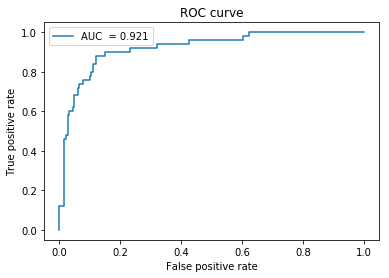

In [25]:
plot_roc_auc(labels_test, predicted_test)

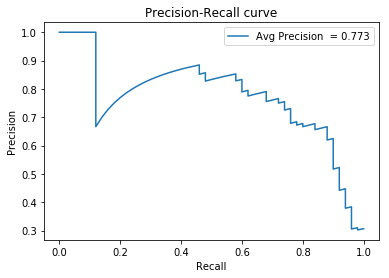

In [26]:
plot_precision_recall(labels_test, predicted_test)

In [27]:
test_df = pd.DataFrame(test_pairs, columns=['voice_a', 'voice_b', 'label'])
test_df['scores'] = predicted_test
test_df.head()

,voice_a,voice_b,label,scores
0,Xander_English_2.mp3,Rose_Portuguese_3.m4a,0,1.788139e-07
1,Xander_English_2.mp3,Other_Spanish_4.mp3,0,4.495302e-02
2,Xander_English_2.mp3,Xander_English_5.m4a,1,9.266121e-01
3,Xander_English_2.mp3,Xander_English_3.mp3,1,1.551955e-01
4,Xander_English_2.mp3,Other_Spanish_5.mp3,0,1.749396e-05


In [28]:
false_positives = (test_df['scores'] > 0.5) & (test_df['label'] == 0)
test_df[false_positives]

,voice_a,voice_b,label,scores
21,Rose_Portuguese_3.m4a,Other_Spanish_4.mp3,0,0.818458
24,Rose_Portuguese_3.m4a,Other_Spanish_5.mp3,0,0.918263
42,Other_Spanish_4.mp3,Xander_English_3.mp3,0,0.836386
44,Other_Spanish_4.mp3,Xander_English_4.mp3,0,0.500732
46,Other_Spanish_4.mp3,Rose_Portuguese_1.m4a,0,0.900050
52,Other_Spanish_4.mp3,Rose_Portuguese_2.m4a,0,0.998867
53,Other_Spanish_4.mp3,Rose_Portuguese_4.m4a,0,0.995651
59,Other_Spanish_4.mp3,Rose_Portuguese_5.m4a,0,0.995770
80,Xander_English_3.mp3,Carlos_English_1.m4a,0,0.601949
112,Xander_English_4.mp3,Rose_Portuguese_1.m4a,0,0.597183


In [29]:
false_negatives = (test_df['scores'] < 0.5) & (test_df['label'] == 1)
test_df[false_negatives]

,voice_a,voice_b,label,scores
3,Xander_English_2.mp3,Xander_English_3.mp3,1,0.155196
67,Xander_English_5.m4a,Xander_English_1.mp3,1,0.427906
91,Xander_English_3.mp3,Xander_English_6.m4a,1,0.172370
98,Other_Spanish_5.mp3,Other_Spanish_2.mp3,1,0.156061
101,Other_Spanish_5.mp3,Other_Spanish_3.mp3,1,0.296727
134,Carlos_English_1.m4a,Carlos_Portuguese_1.m4a,1,0.000052
138,Carlos_English_1.m4a,Carlos_English_3.m4a,1,0.021250
167,Carlos_English_2.m4a,Carlos_Portuguese_2.m4a,1,0.112935
174,Carlos_English_2.m4a,Carlos_English_3.m4a,1,0.120106
198,Carlos_Portuguese_2.m4a,Carlos_Portuguese_3.m4a,1,0.000082


### Production

In [ ]:
PROD_PATH = DATA_PATH + 'production/'
REF_CLIP = PROD_PATH + 'ref_clip.wav'
REF_CLIPS_PICKLE = PROD_PATH + 'ref_clips.pickle'
BEST_MODEL_PATH = DATA_PATH + 'production/model/'
SCORE_THRESHOLD = 0.5
REF_CLIPS = None
MODEL = None

In [ ]:
def get_clips(clip_path, recorded_byte_array, min_size=1):    
    """
    Splits a long clip in multiple smaller clips with MFCC length of 400. 
    Also discards the final part of the audio file the is not a multiple of 400.
    """
    
    #TODO: this function should also work with a recorded byte array
    # since we don't need to save the user's voice everytime they try to open the door
    
    pad_length = 400
    
    wave, sr = librosa.load(clip_path, mono=True)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=sr).astype(np.float32)
        
    n_clips = int(mfcc.shape[1] / pad_length)
    
    if (n_clips < min_size):
        raise Exception('Audio file too short. Expected MFCC equal or greater than {}, but was: {}'.format(
            min_size*400, mfcc.shape[1]))
    
    # cut the recording in smaller clips
    ref_clips = []
    for i in range(1, n_clips+1):
        ref_clips.append(mfcc[:, (i-1)*pad_length:i*pad_length])
        
    # REMOVED: a tiny part could lead to a bad score
    # add the last clip and fill with zeros up to 400
    #last = mfcc[:, n_clips*pad_length:mfcc.shape[1]]
    #if(last.shape[1] > 0): 
    #    ref_clips.append(np.pad(
    #        last, 
    #        pad_width = ((0, 0), (0, pad_length - last.shape[1])),
    #        mode = 'constant'))
    
    return ref_clips
    

In [ ]:
def setup_voice_system():   
    """
    Records the voice of the user, splits the voice in small clippings and saves
    the clippings for later inference.
    """
    
    #TODO
    #record the voice and save the file in path REF_CLIP
    #if time allows, multiple users to open the door
    
    # expect at least 3 clips from reference recording 
    ref_clips = get_clips(REF_CLIP, 3)
    
    with open(REF_CLIPS_PICKLE, 'wb') as handle: 
        pickle.dump(ref_clips, handle)   

In [ ]:
def start_voice_system():
    """
    Loads the reference clippings and the weights of the model.
    """
    
    try:
        with open(REF_CLIPS_PICKLE, 'rb') as handle:
            REF_CLIPS = pickle.load(handle) 
    except Exception as e:
        raise Exception('Could not find reference voice clips. Was the system set up?')

        
    MODEL = models.load_model(BEST_MODEL_PATH)    
        
    try:
        with open(REF_CLIPS_PICKLE, 'rb') as handle:
            ref_clips = pickle.load(handle) 
    except Exception as e:
        raise Exception('Could not find reference voice clips. Was the system set up?')
        
    return ref_clips, model
    

In [ ]:
def get_user_voice():
    """
    Record the user voice anr return smaller processed MFCC clippings
    """
    # TODO
    recorded_byte_array = np.array()
    
    return get_clips(None, recorded_byte_array, min_size=1):   
    

In [ ]:
def get_inference_dataset(actual_clips):
    left = []
    right = []
    
    for ref in REF_CLIPS:
        for actual in actual_clips:
            left.append([ref]) 
            right.append([actual]) 
    
    left = np.array(left).astype(np.float32)
    right = np.array(right).astype(np.float32)

    left = np.rollaxis(np.rollaxis(left, 3, 1), 3, 1)
    right = np.rollaxis(np.rollaxis(right, 3, 1), 3, 1)

    return left, right

In [ ]:
def speech_unlock(left, right):
    return np.mean(MODEL.predict([left, right])) > SCORE_THRESHOLD

In [ ]:
# main.py in TX2 should contain something like this

setup_voice_system()

start_voice_system()

actual_clips = get_user_voice()

left, right = get_inference_dataset(ref_clips, actual_clips)

unlock = speech_unlock(left, right)

if (unlock):
    #do something